## IC Model

In [394]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
%matplotlib inline

class Agent:
    def  __init__(self,id):
        self.id = id
        self.choice = None
        self.strategy = None # hold
        self.buy = p_buy
        self.sell = p_sell

        
def count():
    delta = sum(list(map(lambda agent:agent.strategy, agent_list)))
    return delta

def extract_influencers(G):
#     PCT = 0.2 #choose as influencer from upper "pct" of degree centrality
    degree_centers = nx.degree_centrality(G)
    degree_list = sorted(degree_centers.items(), key=lambda x: x[1], reverse=True)
    influencers = [agent_list[degree_list[i][0]] for i in range(len(G))][0:int(len(G)*PCT)]
    return influencers

def  init_decision():
    random.seed(None)
    for focal in agent_list:
        r = rnd.random()
        if 0<= r<focal.buy:
            focal.choice = 'buy'
            focal.strategy = 1
        elif focal.buy<=r<=focal.buy+focal.sell:
            focal.choice = 'sell'
            focal.strategy = -1
        else: 
            focal.choice = 'hold'
            focal.strategy= 0

### Independent cascade diffusion

In [395]:
def IC_model_diffusion(G, diffusion_probability):
    DPROB = diffusion_probability     #拡散確率
    init_decision()
    influencers = extract_influencers(G)
    influencers_list = [i.id for i in influencers]   
#     print("init decision",[agent_list[i].choice for i in range(len(G))])
#     print("influencer",influencers_list)
#     print ("influencer's choice",[agent_list[i].choice for i in influencers_list])


    informed = []
    informed.extend(influencers_list) # 始めにインフルエンサーを格納しておく
    state = "ongoing" # state is "ongoing" or "end". if "ongoing" difussion go next step otherewise finish.

    while state == "ongoing":
        state = "end"

        # opinions の中にインフルエンサーによる決断の影響を格納
        opinions = [{"buy":0,"sell":0,"hold":0} for i in range(len(G))] # reset opinions
        #print("inf list",[i.id for i in influencers])
        for infl in influencers:
            for focal in G.neighbors(infl.id) :
                opinions[focal][infl.choice] +=1 
        influencers = [] # reset
        #print("opinion",opinions)

        for focal in agent_list:
            if focal.id not in informed:
                i = focal.id
                if opinions[i]['sell']!=0 or opinions[i]['buy']!=0 or opinions[i]['hold']!=0:
                    r = rnd.random()
                    if 0< r < DPROB: # 同調する場合
                        buy_p = opinions[i]['buy'] /(opinions[i]['sell']+opinions[i]['buy']+ opinions[i]['hold'])
                        sell_p = opinions[i]['sell'] /(opinions[i]['sell']+opinions[i]['buy']+ opinions[i]['hold'])
                        hold_p = opinions[i]['hold'] /(opinions[i]['sell']+opinions[i]['buy']+ opinions[i]['hold'])
                        if 0<= r<buy_p:
                            focal.choice = 'buy'
                            focal.strategy = 1
                        elif buy_p<=r<=buy_p+sell_p:
                            focal.choice = 'sell'
                            focal.strategy = -1
                        else: 
                            focal.choice = 'hold'
                            focal.strategy= 0
                    state = "ongoing" # 次の拡散へ続く
                    informed.append(i)
                    influencers.append(agent_list[i])
#     print([i.choice for i in agent_list])
    return count()

### Set propoerty

/Users/puca/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


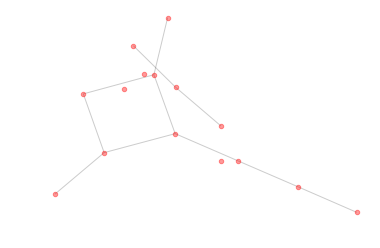

<Figure size 1440x1080 with 0 Axes>

In [740]:
N = 15
p_sell =0.4
p_buy =0.4
num_play = 365*3
G = nx.gnp_random_graph(N,0.1)
agent_list = [Agent(id) for id in range(len(G))]
# PCT = 0.02 #choose as influencer from upper "pct" of degree centrality
G = G.copy()
pos=nx.spring_layout(G)
pos2 =nx.spectral_layout(G)
pos3 =nx.circular_layout(G)
pos4 = nx.random_layout(G)
pos5  =nx.shell_layout(G)
pos7 =nx.kamada_kawai_layout(G)

nx.draw_networkx_edges(G,pos7,alpha=0.2)
nx.draw_networkx_nodes(G,pos7,alpha=0.4,node_size=20)
# nx.draw(G,pos,node_size=20)
plt.axis('off')
plt.figure(figsize=(20,15))
plt.show()

#### 変動量が異なるのがわかる

In [688]:
# 1)
init_decision()
count1 = count()
# 2)
count2 =  IC_model_diffusion(G,1)
print ("random:",count1)
print ("IC_model",count2)

random: -4
IC_model -25


In [689]:
def get_colors():
    global  color_list
    colors = []
    infl_id = [focal.id for focal in extract_influencers(G)]
    for focal in agent_list:
        if focal.choice =="buy":
            colors.append("red")
        elif focal.choice =="sell":
            colors.append("blue")
        else:
            colors.append("black")

    color_list.append(colors)

#### visualization of ic model

In [690]:
def get_colors():
    global  color_list
    colors = []
    for focal in agent_list:
        if focal.choice =="buy":
            colors.append("red")
        elif focal.choice =="sell":
            colors.append("blue")
        else:
            colors.append("black")
    color_list.append(colors)

# print(color_list)

In [741]:
# def IC_model_for_visualization(G, diffusion_probability):
DPROB = 1    #拡散確率
PCT = 0.1

color_list=[]
init_decision()
get_colors()
# print(color_list)



#------------------------------------------------------------


influencers = extract_influencers(G)
influencers_list = [i.id for i in influencers]   
infl_id = [focal.id for focal in extract_influencers(G)]
#     print("init decision",[agent_list[i].choice for i in range(len(G))])
#     print("influencer",influencers_list)
#     print ("influencer's choice",[agent_list[i].choice for i in influencers_list])


informed = []
informed.extend(influencers_list) # 始めにインフルエンサーを格納しておく
state = "ongoing" # state is "ongoing" or "end". if "ongoing" difussion go next step otherewise finish.

while state == "ongoing":
    state = "end"

    # opinions の中にインフルエンサーによる決断の影響を格納
    opinions = [{"buy":0,"sell":0,"hold":0} for i in range(len(G))] # reset opinions
    print("inf list",[i.id for i in influencers])
    for infl in influencers:
        for focal in G.neighbors(infl.id) :
            opinions[focal][infl.choice] +=1 
    influencers = [] # reset
    #print("opinion",opinions)

    for focal in agent_list:
        if focal.id not in informed:
            i = focal.id
            if opinions[i]['sell']!=0 or opinions[i]['buy']!=0 or opinions[i]['hold']!=0:
                r = rnd.random()
                if 0< r < DPROB: # 同調する場合
                    buy_p = opinions[i]['buy'] /(opinions[i]['sell']+opinions[i]['buy']+ opinions[i]['hold'])
                    sell_p = opinions[i]['sell'] /(opinions[i]['sell']+opinions[i]['buy']+ opinions[i]['hold'])
                    hold_p = opinions[i]['hold'] /(opinions[i]['sell']+opinions[i]['buy']+ opinions[i]['hold'])
                    if 0<= r<buy_p:
                        focal.choice = 'buy'
                        focal.strategy = 1
                    elif buy_p<=r<=buy_p+sell_p:
                        focal.choice = 'sell'
                        focal.strategy = -1
                    else: 
                        focal.choice = 'hold'
                        focal.strategy= 0
                state = "ongoing" # 次の拡散へ続く
                informed.append(i)
                influencers.append(agent_list[i])
    if state =="ongoing":           
        get_colors()
#     print([i.choice for i in agent_list])
# return count(),color_list

len(color_list)

inf list [4, 9, 10]
inf list [1, 8, 12, 14]
inf list [0]
inf list [11]


4

/Users/puca/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/puca/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


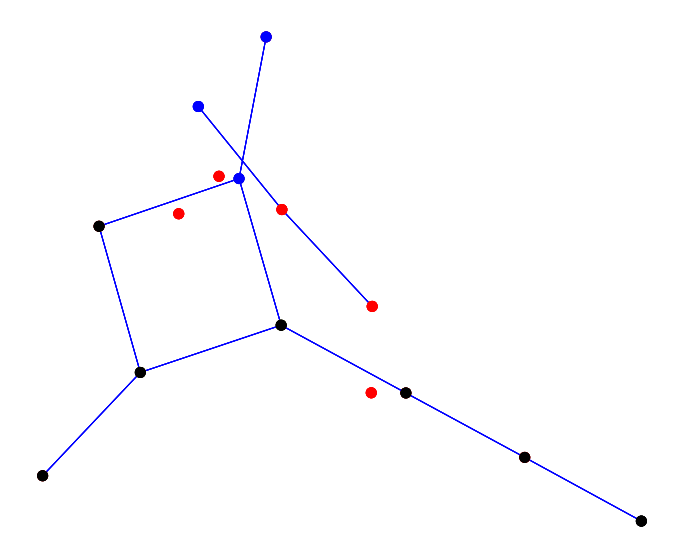

In [742]:
#インフルエンサーは黄色
init_color = color_list[0].copy()
for i in infl_id:
    init_color[i] = "yellow" 

#可視化    
num = len(color_list)
fig= plt.figure(figsize= (12,10))
ax  =fig.add_subplot(111)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(color="white")
    
#influencer = yellow   
nx.draw_networkx_edges(G,pos7,edge_color="blue",ax = ax,alpha  =0.9)
nx.draw_networkx_nodes(G,pos7,node_color=init_color, ax = ax,node_size=100,alpha =0.9)
plt.savefig('/Users/puca/thesis/images/ICmodel_simulation/n=15_init.png')

for i in range (num):
    ax  =fig.add_subplot(111)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(color="white")
    nx.draw_networkx_edges(G,pos7,edge_color="blue",ax = ax,alpha =0.9)
    nx.draw_networkx_nodes(G,pos7,node_color=color_list[i], ax = ax,alpha =0.9,node_size=100)
    plt.savefig('/Users/puca/thesis/images/ICmodel_simulation/n=15_{}.png'.format(i))
    


plt.axis('off')
plt.show()


In [486]:
#インフルエンサーは黄色
init_color = color_list[0].copy()
for i in infl_id:
    init_color[i] = "yellow" 

#可視化    
num = len(color_list)
fig,ax = plt.subplots(num+1,1,figsize= (12,10*num))
[ax[i].set_xticklabels([]) for i in range(num+1)] 
[ax[i].set_yticklabels([]) for i in range(num+1)] 
for i in range(num+1):
    ax[i].set_xticklabels([]) 
    ax[i].set_yticklabels([]) 
    ax[i].tick_params(color = "white") 
    
#influencer = yellow   
nx.draw_networkx_edges(G,pos7,edge_color="blue",ax = ax[0],alpha  =0.9)
nx.draw_networkx_nodes(G,pos7,node_color=init_color, ax = ax[0],node_size=100,alpha =0.9)

for i in range (num):
    nx.draw_networkx_edges(G,pos7,edge_color="blue",ax = ax[i+1],alpha =0.9)
    nx.draw_networkx_nodes(G,pos7,node_color=color_list[i], ax = ax[i+1],alpha =0.9,node_size=100)

# plt.savefig('influencer2%.png')
plt.axis('off')
plt.figure(figsize=(20,15))
plt.show()


0
1


In [5]:
def priceSeries():
    random.seed(None)
    price = 0
    prices = [price]
    delta_series = []
    # generate first L days series by random walk  for calculating R(t)
    for i in range(L):
        init_decision()
        delta = count()
        price+=delta
        prices.append(price)
        delta_series.append(delta)

    for play in range(num_play):
        delta = IC_model_diffusion(G,1)
        price +=delta
        prices.append(price)
        delta_series.append(delta)
#     plt.plot(prices[:])
    return prices, delta_series

#### ICモデルの同調行動の適用前後(step = 500)の価格変動量

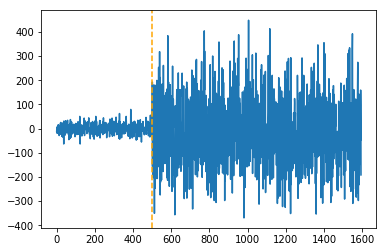

In [6]:
L = 500
prices,delta_series = priceSeries()
plt.plot(delta_series)
plt.axvline(x = 500, linestyle = "dashed",color = "orange")

### volatility with defferent diffusion probabolities

In [7]:
def priceSeries_test2(): 
    price = 0
    prices = [price]
    delta_series = []
    # generate first L days series by random walk  for calculating R(t)
    diffusion_probability = 0
    for play in range(1200):
        if play%200 == 0 and play !=0:
            diffusion_probability +=0.2
        delta = IC_model_diffusion(G,diffusion_probability)
        price +=delta
        prices.append(price)
        delta_series.append(delta)
#     plt.plot(prices[:])
    return prices, delta_series
prices, delta_series = priceSeries_test2()

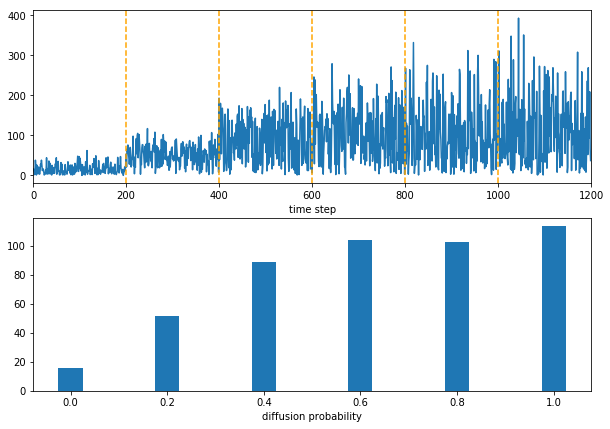

In [8]:
fig,ax= plt.subplots(2,1,figsize=(10,7))
abs_delta =np.abs(delta_series)
ax[0].plot(abs_delta)
for i in range(5):
    ax[0].axvline(x = 200*(i+1), linestyle = "dashed",color = "orange")
s = []
for loc in range(6):
    tmp = np.average(abs_delta[loc*200:loc*200+200])
    s.append(tmp)
ax[1].bar([0+0.2*i for i in range(6)],s,width = 0.05)
ax[0].set_xlim([0,1200]) 
ax[0].set_xlabel("time step")
ax[1].set_xlabel("diffusion probability")
plt.show()

#### 拡散係数の算出

It has been reported in that the relative portion $\xi_l$ of investors with a $l$ days investment horizon follows a power-law decay,
$$
 \xi_l = \frac{l^{-1.12}}{\sum^L_{l=1}l^{-1.12}}
$$

so I introduce a weighted average retrun $R'(t)$ defined as
$$
R'(t) = k\sum^L_{l=1}[\xi_l \sum^{l-1}_{m=0}R(t-m)]
$$

where $R(t)$ is price return and cofficeint $k$ is set as 
$$
k = \frac{1}{\sum^L_{l=1}\sum^L_{m=l}\xi_m}
$$

In [9]:
L = 30 # 
alpha = 5/N # deffusion_probability takes in range [0.076, 0.924]

def  xi(l):
    ans = 0
    for l in range(1,L+1):
        ans+= l**-1.12
    return l**-1.12/ans

def ave_return(pct_price):
    r = 0
    # cofficient k
    k = 0
    for l in range(1,L+1):
        for m in range(l,L+1):
            k  += xi(m)
    for l in range(1,L+1):
        for m in range(0,l):
            r += xi(l)*pct_price[-m-1] # -N<=r<=N  # prices じゃなくて変動率で算出しないとだめ
    return np.abs(k*r)

print(ave_return(prices))

def deffusion_probability(prices):
    r = ave_return(prices)-N/2
    print(r)
    return 1/(1+np.exp(-alpha*r))
    
# deffusion_probability(prices)

TypeError: ave_return() takes 0 positional arguments but 1 was given